BERT, Classfication layer

BERT, Classfication layer

In [1]:
name = "bert_final_interpreted"

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


train_data = pd.read_csv('../datasets/data_train_2.csv')
train_data['label'] = train_data['label'].replace({'meniskus-urgent': 'meniscus-urgent', 'meniskus-minor': 'meniscus-minor'})
test_data = pd.read_csv('../datasets/data_test_2.csv')
test_data['label'] = test_data['label'].replace({'meniskus-urgent': 'meniscus-urgent', 'meniskus-minor': 'meniscus-minor'})
valid_data = pd.read_csv('../datasets/data_valid_2.csv')
valid_data['label'] = valid_data['label'].replace({'meniskus-urgent': 'meniscus-urgent', 'meniskus-minor': 'meniscus-minor'})


all_labels = pd.concat([train_data["label"], test_data["label"], valid_data["label"]])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

LabelEncoder()

In [3]:
def extract_texts_labels(data, label_encoder):
    texts = data['data'].values
    labels = data['label'].values
    encoded_labels = label_encoder.transform(labels)
    return texts, encoded_labels

In [4]:
from sklearn.utils import shuffle

df = train_data.copy()

print("Original Class Distribution:")
print(df['label'].value_counts())

# Specify minority classes directly
minority_labels = ['cruciate-ligament-minor', 'cruciate-ligament-urgent', 'meniscus-minor']

# Calculate the number of samples needed to match the most populous class
class_counts = df['label'].value_counts()
majority_class_count = class_counts.max()

# Initialize an empty dataframe to collect oversampled data
oversampled_dfs = [df]

for label in minority_labels:
    minority_df = df[df['label'] == label]
    required_samples = majority_class_count - class_counts[label]
    replication_factor = required_samples // len(minority_df)  # Calculate replication factor
    oversampled_minority_df = pd.concat([minority_df] * replication_factor, ignore_index=True)
    oversampled_dfs.append(oversampled_minority_df)

# Combine the original dataframe with the oversampled minority dataframes
balanced_df = pd.concat(oversampled_dfs, ignore_index=True)

# Shuffle the dataset
balanced_df = shuffle(balanced_df, random_state=42)
train_data = balanced_df.copy()

print("New Class Distribution After Shuffling:")
print(balanced_df['label'].value_counts())

Original Class Distribution:
label
other-minor                 9633
meniscus-urgent             9185
cruciate-ligament-urgent    2377
meniscus-minor              1657
cruciate-ligament-minor      354
Name: count, dtype: int64
New Class Distribution After Shuffling:
label
other-minor                 9633
cruciate-ligament-minor     9558
cruciate-ligament-urgent    9508
meniscus-urgent             9185
meniscus-minor              8285
Name: count, dtype: int64


In [5]:
train_texts, train_labels = extract_texts_labels(train_data, label_encoder)
test_texts, test_labels = extract_texts_labels(test_data, label_encoder)
valid_texts, valid_labels = extract_texts_labels(valid_data, label_encoder)


In [6]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("GerMedBERT/medbert-512")

# Tokenize the data
train_encodings = tokenizer(train_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
test_encodings = tokenizer(test_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
valid_encodings = tokenizer(valid_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)

In [7]:
import tensorflow as tf

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

train_dataset = create_dataset(train_encodings, train_labels)
test_dataset = create_dataset(test_encodings, test_labels)
valid_dataset = create_dataset(valid_encodings, valid_labels)

2024-08-11 01:56:09.319702: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-08-11 01:56:09.319730: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-08-11 01:56:09.319734: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-08-11 01:56:09.319751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-11 01:56:09.319764: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
from transformers import TFBertModel

# Load the BERT model for sequence classification with the number of output labels
bert_model = TFBertModel.from_pretrained("GerMedBERT/medbert-512", num_labels=len(label_encoder.classes_), output_hidden_states = True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-

In [9]:
input_ids = tf.keras.Input(shape=(400,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(400,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model([input_ids, attention_mask])
sequence_output = bert_output.last_hidden_state

# Pooling layer
pooled_output = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)

# Add a dropout layer
pooled_output = tf.keras.layers.Dropout(0.3)(pooled_output)

# Add a classification layer
output = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(pooled_output)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

In [10]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[ "accuracy" ]
)


In [11]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_epoch_{epoch}.keras',  # Path where the model will be saved
    save_weights_only=False,            # If False, the whole model will be saved
    save_best_only=False,               # Save the model after every epoch
    verbose=1                           # Verbosity mode
)

In [12]:
# Train the model with early stopping callback
history = model.fit(train_dataset.shuffle(1000).batch(32),
          validation_data=valid_dataset.batch(32),
          epochs=10,
          callbacks=[checkpoint_callback]
          )


Epoch 1/10


/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/engine/functional.py:641: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2024-08-11 01:56:47.619697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1443/1443 [==============================] - ETA: 0s - loss: 1.0515 - accuracy: 0.5493
Epoch 1: saving model to model_epoch_1.keras


/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


1443/1443 [==============================] - 2899s 2s/step - loss: 1.0515 - accuracy: 0.5493 - val_loss: 1.1997 - val_accuracy: 0.4817
Epoch 2/10
1443/1443 [==============================] - ETA: 0s - loss: 0.5943 - accuracy: 0.7445
Epoch 2: saving model to model_epoch_2.keras
1443/1443 [==============================] - 2899s 2s/step - loss: 0.5943 - accuracy: 0.7445 - val_loss: 1.0381 - val_accuracy: 0.6044
Epoch 3/10
1443/1443 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8228
Epoch 3: saving model to model_epoch_3.keras
1443/1443 [==============================] - 2905s 2s/step - loss: 0.4070 - accuracy: 0.8228 - val_loss: 1.2514 - val_accuracy: 0.5901
Epoch 4/10
1443/1443 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.8699
Epoch 4: saving model to model_epoch_4.keras
1443/1443 [==============================] - 2904s 2s/step - loss: 0.3095 - accuracy: 0.8699 - val_loss: 1.1706 - val_accuracy: 0.6443
Epoch 5/10
1443/1443 [=========

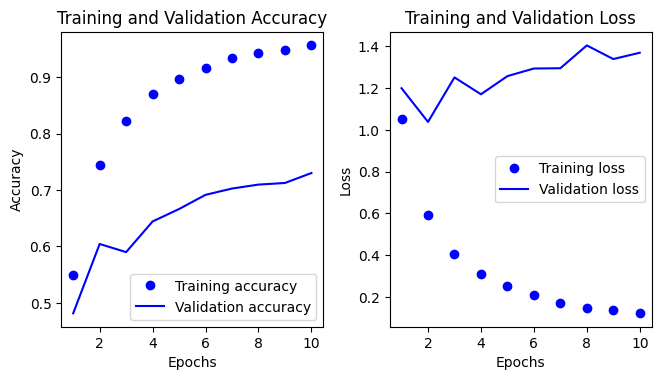

In [13]:
import matplotlib.pyplot as plt
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

# Metrics to plot
metrics_names = ["accuracy",'loss']

plt.figure(figsize=(10, 7))

for i, metric in enumerate(metrics_names, 1):
    plt.subplot(2, 3, i)
    plt.plot(epochs, history_dict[metric], 'bo', label=f'Training {metric}')
    plt.plot(epochs, history_dict[f'val_{metric}'], 'b', label=f'Validation {metric}')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(32))
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

242/242 [==============================] - 166s 686ms/step - loss: 1.3363 - accuracy: 0.7376
Loss: 1.3362908363342285
Accuracy: 0.737592339515686


In [15]:
model.save(name + ".h5")
tokenizer.save_pretrained(name + "_tokenizer")

/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


('bert_final_interpreted_tokenizer/tokenizer_config.json',
 'bert_final_interpreted_tokenizer/special_tokens_map.json',
 'bert_final_interpreted_tokenizer/vocab.txt',
 'bert_final_interpreted_tokenizer/added_tokens.json')

In [16]:
import numpy as np
predictions = model.predict(test_dataset.batch(32))
predicted_labels = np.argmax(predictions, axis=1)

# Decode class labels to original labels
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# True labels from the test set
true_labels = label_encoder.inverse_transform(test_labels)

# Create a DataFrame to compare
comparison_df = pd.DataFrame({'Text': test_texts, 'True Label': true_labels, 'Predicted Label': decoded_predictions})

/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/engine/functional.py:641: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


242/242 [==============================] - 167s 674ms/step


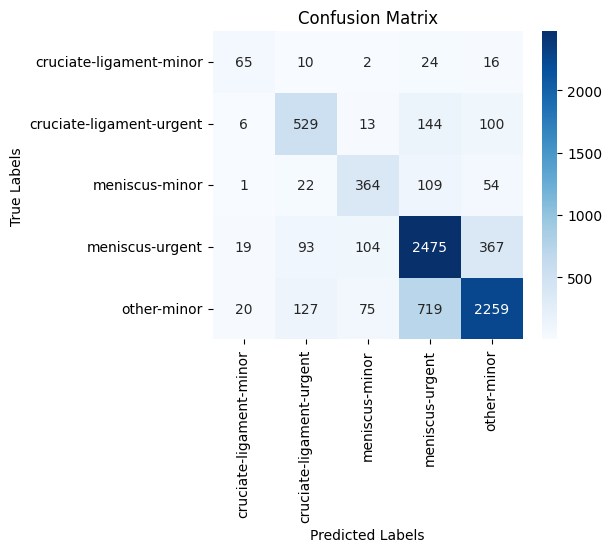

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, decoded_predictions, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

 cruciate-ligament-minor       0.59      0.56      0.57       117
cruciate-ligament-urgent       0.68      0.67      0.67       792
          meniscus-minor       0.65      0.66      0.66       550
         meniscus-urgent       0.71      0.81      0.76      3058
             other-minor       0.81      0.71      0.75      3200

                accuracy                           0.74      7717
               macro avg       0.69      0.68      0.68      7717
            weighted avg       0.74      0.74      0.74      7717



In [19]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_, output_dict=True)

In [20]:
df = pd.DataFrame(report).transpose()
df.to_csv(name + "_report.csv")

In [21]:
model.save(name, save_format = "tf")
model.save(name + ".keras")

INFO:tensorflow:Assets written to: bert_final_interpreted/assets


INFO:tensorflow:Assets written to: bert_final_interpreted/assets
/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
